In [7]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from maayanlab_bioinformatics.normalization import zscore_normalize, log2_normalize
from scipy.stats import zscore
import qnorm
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [8]:
def make_umap(rna_df):   
    adata = sc.AnnData(log2_normalize(qnorm.quantile_normalize(rna_df)).T.values, dtype="float")
    adata.var['gene_names'] = rna_df.index.values
    adata.obs['samples'] = rna_df.columns.values
    # Sort genes by variance
    adata.var['var_rank'] = (-np.var(adata.X, axis=0, dtype="float")).argsort()
    adata = adata[:, adata.var.var_rank < 5000]
    max_score = -1
    best_n_neighbors = None
    best_resolution = None
    best_min_dist = None
    sc.pp.pca(adata)
    for n_neighbors in tqdm(range(3, 20, 1)):
        start = 0.3
        end = 1.5
        step = 0.1
        for resolution in [start + i * step for i in range(int((end - start) / step) + 1)]:
            for min_dist in [0.3, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001]:
                sc.pp.neighbors(adata, n_neighbors=n_neighbors)
                sc.tl.umap(adata, min_dist=min_dist, alpha=0.1)  # embed umap based on neighborhood graph
                sc.tl.leiden(adata, resolution=resolution)  # clustering
                if len(adata.obs['leiden'].unique()) < 3:
                    continue
                score = silhouette_score(adata.obsm['X_umap'], adata.obs['leiden'])
                if score > max_score:
                    max_score = score
                    best_n_neighbors = n_neighbors
                    best_resolution = resolution
                    best_min_dist = min_dist
                    print(n_neighbors, resolution, min_dist, score)
    print(f"Best n_neighbors: {best_n_neighbors}, Best resolution: {best_resolution}")
    return best_n_neighbors, best_resolution, best_min_dist

def plot_umap(rna_df, n_neighbors, resolution, min_dist=0.01):
    adata = sc.AnnData(log2_normalize(qnorm.quantile_normalize(rna_df)).T.values, dtype="float")
    adata.var['gene_names'] = rna_df.index.values
    adata.obs['samples'] = rna_df.columns.values
    # Sort genes by variance
    adata.var['var_rank'] = (-np.var(adata.X, axis=0, dtype="float")).argsort()
    adata = adata[:, adata.var.var_rank < 5000]
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)  # create neighborhood graph,
    sc.tl.umap(adata, min_dist=min_dist, alpha=0.1)  # embed umap based on neighborhood graph,
    sc.tl.leiden(adata, resolution=resolution)  # clustering,
    clusters = adata.obs['leiden'].unique()
    cmap = plt.cm.get_cmap('tab20b', len(clusters))
    for i, cluster in enumerate(sorted(clusters)):
        mask = adata.obs['leiden'] == cluster
        ax = plt.scatter(x=adata.obsm['X_umap'][mask, 0], y=adata.obsm['X_umap'][mask, 1], color=cmap(i), label=f'Cluster {cluster}', s=10)
    plt.legend(title='Leiden clusters', bbox_to_anchor=(1.05, 1), loc='best')
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    plt.xlabel('UMAP-1')
    plt.ylabel('UMAP-2')


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.42919725
3 0.3 0.2 0.4483959
3 0.3 0.05 0.47811994
3 0.3 0.01 0.53347313
3 0.8 0.01 0.53716534


  6%|▌         | 1/17 [00:37<10:01, 37.60s/it]

4 0.3 0.05 0.5948482


100%|██████████| 17/17 [12:05<00:00, 42.69s/it]


Best n_neighbors: 4, Best resolution: 0.3
4 0.3 0.05


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


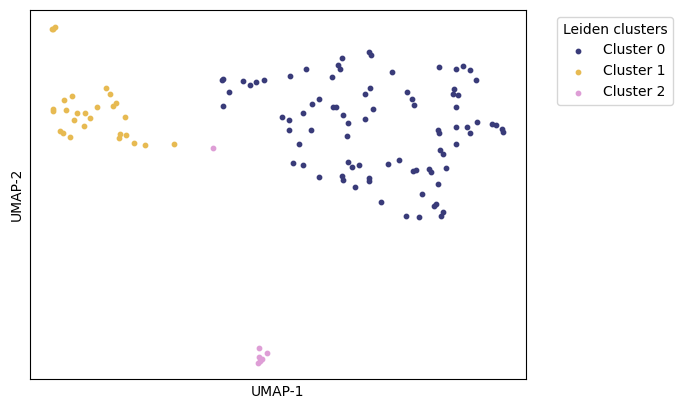

In [9]:
ct = 'BR'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.29552144
3 0.3 0.2 0.33383584
3 0.3 0.1 0.35542348
3 0.5 0.01 0.36086515
3 0.6000000000000001 0.1 0.36956757
3 0.7 0.3 0.38581893
3 0.7 0.2 0.43993306
3 0.7 0.1 0.4973233


100%|██████████| 17/17 [11:49<00:00, 41.71s/it]


Best n_neighbors: 3, Best resolution: 0.7
3 0.7 0.1


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


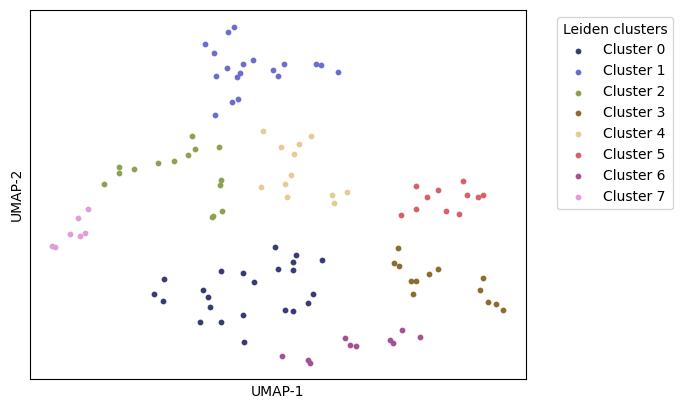

In [10]:
ct = 'CCRCC'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.36712626
3 0.3 0.2 0.39647603
3 0.3 0.1 0.40313366
3 0.3 0.05 0.4473124
3 0.3 0.01 0.4478359
3 0.3 0.001 0.4917842
3 1.2 0.05 0.49815205
3 1.2 0.01 0.51177275
3 1.2 0.001 0.51516235
3 1.2 0.0001 0.51869124
3 1.3 0.0001 0.5241695


100%|██████████| 17/17 [11:45<00:00, 41.50s/it]


Best n_neighbors: 3, Best resolution: 1.3
3 1.3 0.0001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


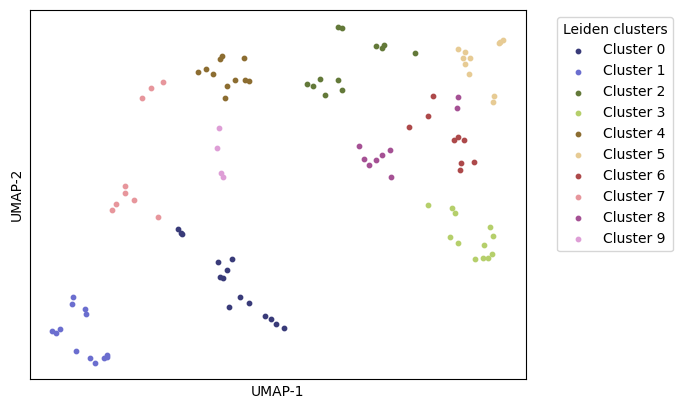

In [11]:
ct = 'CO'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.3435816
3 0.3 0.2 0.37979716
3 0.3 0.1 0.4034988
3 0.3 0.05 0.42671922
3 0.3 0.01 0.45222637
3 0.5 0.01 0.464312
3 0.6000000000000001 0.01 0.47318253
3 0.8 0.05 0.5017747
3 0.8 0.01 0.518979


100%|██████████| 17/17 [12:04<00:00, 42.63s/it]


Best n_neighbors: 3, Best resolution: 0.8
3 0.8 0.01


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


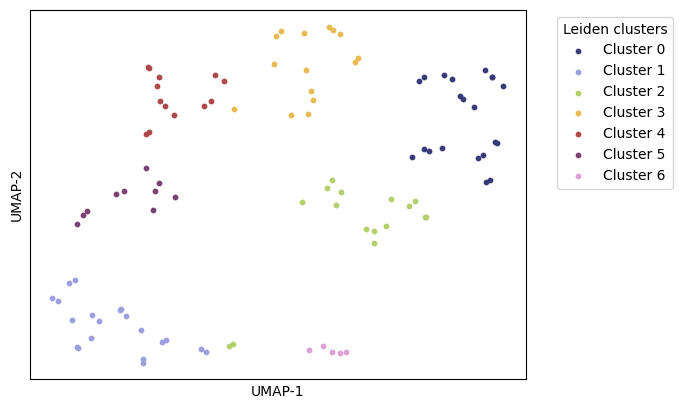

In [12]:
ct = 'GBM'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.34057596
3 0.3 0.1 0.371302
3 0.3 0.05 0.37161702
3 0.3 0.01 0.394713
3 0.3 0.001 0.3985343
3 0.3 0.0001 0.4041666
3 0.4 0.1 0.41968155
3 0.4 0.05 0.42893174
3 0.4 0.01 0.44151682
3 0.4 0.0001 0.4488974
3 0.8 0.05 0.4830879
3 0.8 0.01 0.5147848
3 0.9000000000000001 0.01 0.52661204
3 0.9000000000000001 0.001 0.528425
3 0.9000000000000001 0.0001 0.53497857


  6%|▌         | 1/17 [00:40<10:55, 40.94s/it]

4 0.3 0.001 0.5354288


100%|██████████| 17/17 [12:22<00:00, 43.67s/it]


Best n_neighbors: 4, Best resolution: 0.3
4 0.3 0.001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


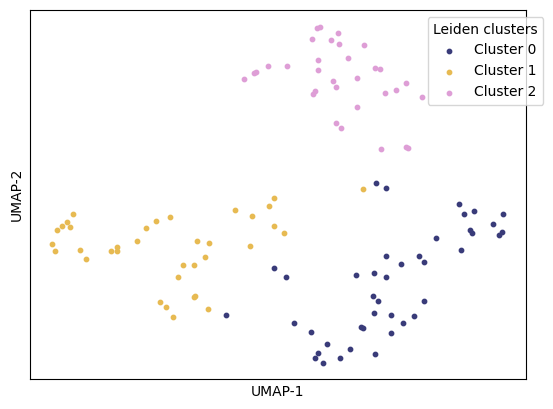

In [13]:
ct = 'HNSCC'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.35116112
3 0.3 0.2 0.3772842
3 0.3 0.1 0.44802913
3 0.3 0.05 0.47844744
3 0.3 0.001 0.5144014
3 0.5 0.05 0.5279338
3 0.5 0.01 0.54571
3 0.5 0.0001 0.546409


100%|██████████| 17/17 [11:59<00:00, 42.30s/it]


Best n_neighbors: 3, Best resolution: 0.5
3 0.5 0.0001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


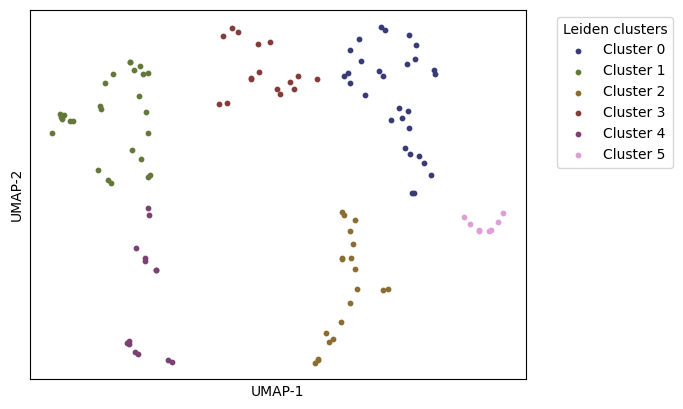

In [14]:
ct = 'LSCC'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.39409348
3 0.3 0.2 0.41303506
3 0.3 0.1 0.50413793
3 0.3 0.01 0.5214505
3 0.3 0.001 0.53374124
3 0.3 0.0001 0.5588154


100%|██████████| 17/17 [12:05<00:00, 42.65s/it]


Best n_neighbors: 3, Best resolution: 0.3
3 0.3 0.0001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


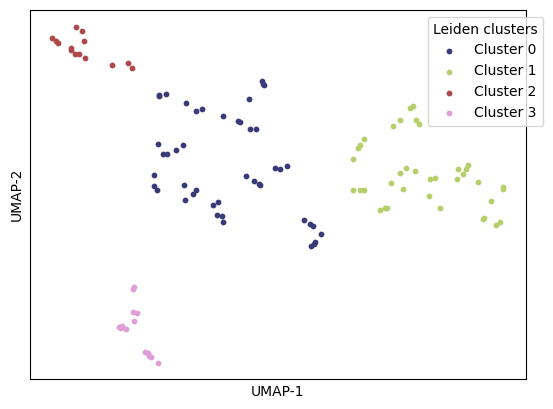

In [15]:
ct = 'LUAD'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.3782236
3 0.3 0.1 0.41344947
3 0.3 0.001 0.42525575
3 0.4 0.2 0.43894708
3 0.4 0.1 0.5002101
3 0.4 0.01 0.5073098
3 0.5 0.001 0.5568311
3 0.8 0.001 0.5871554
3 0.9000000000000001 0.001 0.6053823


100%|██████████| 17/17 [11:09<00:00, 39.39s/it]


Best n_neighbors: 3, Best resolution: 0.9000000000000001
3 0.9000000000000001 0.001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


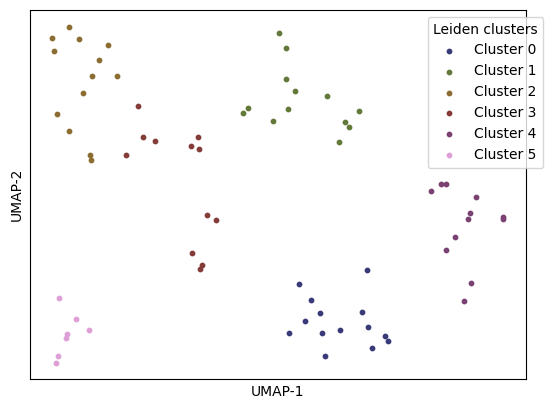

In [16]:
ct = 'OV'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.292281
3 0.3 0.2 0.35993662
3 0.3 0.1 0.37245592
3 0.3 0.05 0.4056366
3 0.3 0.01 0.43469548
3 0.3 0.001 0.4388311
3 0.3 0.0001 0.4584682
3 0.7 0.001 0.47332406
3 0.9000000000000001 0.01 0.50847197
3 0.9000000000000001 0.001 0.5268615


100%|██████████| 17/17 [13:08<00:00, 46.38s/it]


Best n_neighbors: 3, Best resolution: 0.9000000000000001
3 0.9000000000000001 0.001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


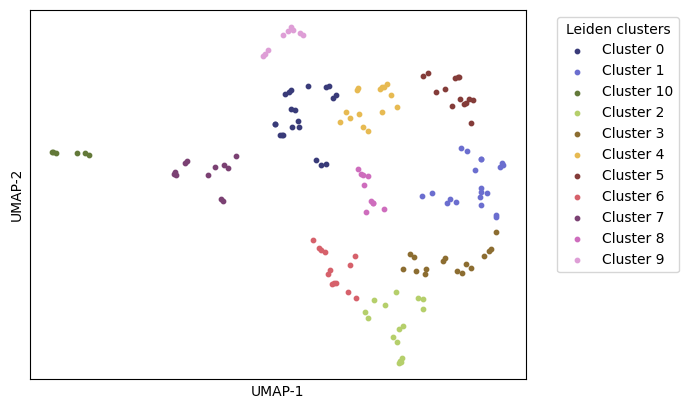

In [17]:
ct = 'PDAC'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
  0%|          | 0/17 [00:00<?, ?it/s]

3 0.3 0.3 0.41334435
3 0.3 0.2 0.42547294
3 0.3 0.1 0.5089421
3 0.3 0.01 0.52916807
3 0.3 0.001 0.544659
3 0.4 0.001 0.5617514


100%|██████████| 17/17 [12:02<00:00, 42.48s/it]


Best n_neighbors: 3, Best resolution: 0.4
3 0.4 0.001


/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_1547/83813565.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(clusters))


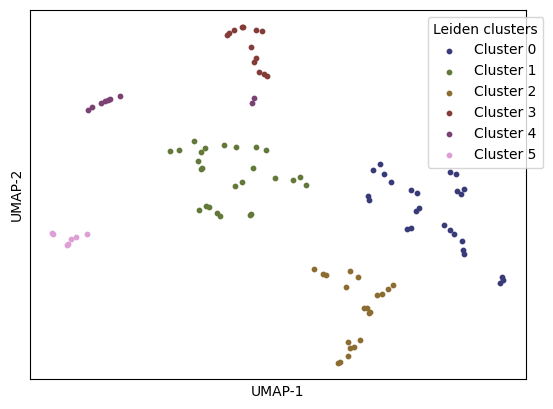

In [18]:
ct = 'UCEC'

rna_df = pd.read_csv(f'out/{ct}_tumor_counts.tsv', index_col=0, sep='\t')
best_n_neighbors, best_resolution, best_min_dist = make_umap(rna_df)
print(best_n_neighbors, best_resolution, best_min_dist)
plot_umap(rna_df, best_n_neighbors, best_resolution, best_min_dist)